In [366]:
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model,load_model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

import pydot
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn

In [367]:
# MODEL IMAGES PATHS
path_to_vgg16_model_image = "model_images/vgg16.png"

# MODEL WEIGHTS PATHS
# set always net path for weights
path_to_vgg16_model_weights = "./vgg16_weights/vgg16_model_weights"

# CSV LOGS PATHS
path_to_vgg16_csvlog = "./csv_logs/vgg16"

# JSON MODEL PRESENTATION PATHS
vgg16_model_json_path = "./json_models/vgg16.json"

# MODEL PATHS
path_to_vgg16_model = "./models/vgg16"


# Number of epochs hyperparameter
num_of_epochs = 50

In [368]:
RANDOM_STATE = 1234

In [369]:
# PATH TO FOOD IMAGES
beans = 'images/BEANS'
cake = 'images/CAKE'
candy = 'images/CANDY'
cereal = 'images/CEREAL'
chips = 'images/CHIPS'
chocolate = 'images/CHOCOLATE'
coffee = 'images/COFFEE'
corn = 'images/CORN'
fish = 'images/FISH'
flour = 'images/FLOUR'
honey = 'images/HONEY'
jam = 'images/JAM'
juice = 'images/JUICE'
milk = 'images/MILK'
nuts = 'images/NUTS'
oil = 'images/OIL'
pasta = 'images/PASTA'
rice = 'images/RICE'
soda = 'images/SODA'
spices = 'images/SPICES'
sugar = 'images/SUGAR'
tea = 'images/TEA'
tomato_sauce = 'images/TOMATO_SAUCE'
vinegar = 'images/VINEGAR'
water = 'images/WATER'

X = []
Z = []
imgsize = 150

In [370]:
def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [371]:
def print_model(model, model_name):
    plot_model(model, to_file = model_name, show_shapes=True, show_layer_names=True)
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [372]:
# VGG16 arhitecture
def vgg16_model(img_rows,img_cols):
    base_model = VGG16(include_top=False,
                      input_shape = (img_rows,img_cols,3),
                      weights = 'imagenet',
                      )

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers:
        print(layer,layer.trainable)

    model = Sequential()
    model.add(base_model)
#     my layers
    model.add(GlobalAveragePooling2D())
#     model.add(Dropout(0.3))
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(25,activation='softmax'))
    model.summary()
    
    return model

In [373]:
def plot_acc_loss(history, num_of_epochs):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(0, num_of_epochs), history.history['loss'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(0, num_of_epochs), history.history['accuracy'], label='train')
    plt.plot(np.arange(0, num_of_epochs), history.history['val_accuracy'], label='val')
    plt.legend(loc='best')

    plt.show()

In [374]:
def evaluate_model(model,x_test,y_test,classes_names,conf_matrix_name):
    score = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    y_predicted = model.predict(x_test)
    y_predicted_classes = np.argmax(y_predicted, axis = 1)
    y_test_classes = np.argmax(y_test, axis = 1)
    
    conf_mat = confusion_matrix(y_test_classes, y_predicted_classes)
    
    df_cm = pd.DataFrame(conf_mat, index = [i for i in classes_names],
                  columns = [i for i in classes_names])
    plt.figure(figsize = (16,12))
    plt.title(conf_matrix_name)
    sn.heatmap(df_cm, annot=True)
    plt.savefig('./confusion_matrices/' + conf_matrix_name)
    
    report = classification_report(y_test_classes, y_predicted_classes)
    print(report)
    
    
    y_predicted_classes.shape, y_test_classes.shape

In [375]:
def write_model_as_json(model, path):
    model_json = model.to_json()
    with open(path,"w") as json_file:
        json_file.write(model_json)

In [376]:
# INITIAL CNN MODEL

# model = Sequential([
#     Input(shape=input_shape),
#     Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.5),
#     Dense(number_of_classes, activation='softmax')
# ])

# model.summary()
# display(SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg')))
# model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
# batch_size = 128
# epochs = 12
# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2)

In [377]:
def test_model():
    model = Sequential([
        Input(shape=(150,150,3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(25, activation='softmax')
    ])
    
    model.summary()
    return model

In [378]:
training_data('beans',beans)
training_data('cake',cake)
training_data('candy',candy)
training_data('cereal',cereal)
training_data('chips',chips)
training_data('chocolate',chocolate)
training_data('coffee',coffee)
training_data('corn',corn)
training_data('fish',fish)
training_data('flour',flour)
training_data('honey',honey)
training_data('jam',jam)
training_data('juice',juice)
training_data('milk',milk)
training_data('nuts',nuts)
training_data('oil',oil)
training_data('pasta',pasta)
training_data('rice',rice)
training_data('soda',soda)
training_data('spices',spices)
training_data('sugar',sugar)
training_data('tea',tea)
training_data('tomato sauce',tomato_sauce)
training_data('vinegar',vinegar)
training_data('water',water)

100%|██████████| 262/262 [00:01<00:00, 230.66it/s]


In [379]:
# shape of image
X[0].shape

(150, 150, 3)

In [380]:
# image data format
K.image_data_format()

'channels_last'

In [381]:
len(X),len(Z)

(4947, 4947)

In [382]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)

In [383]:
Y

array([ 0,  0,  0, ..., 24, 24, 24], dtype=int64)

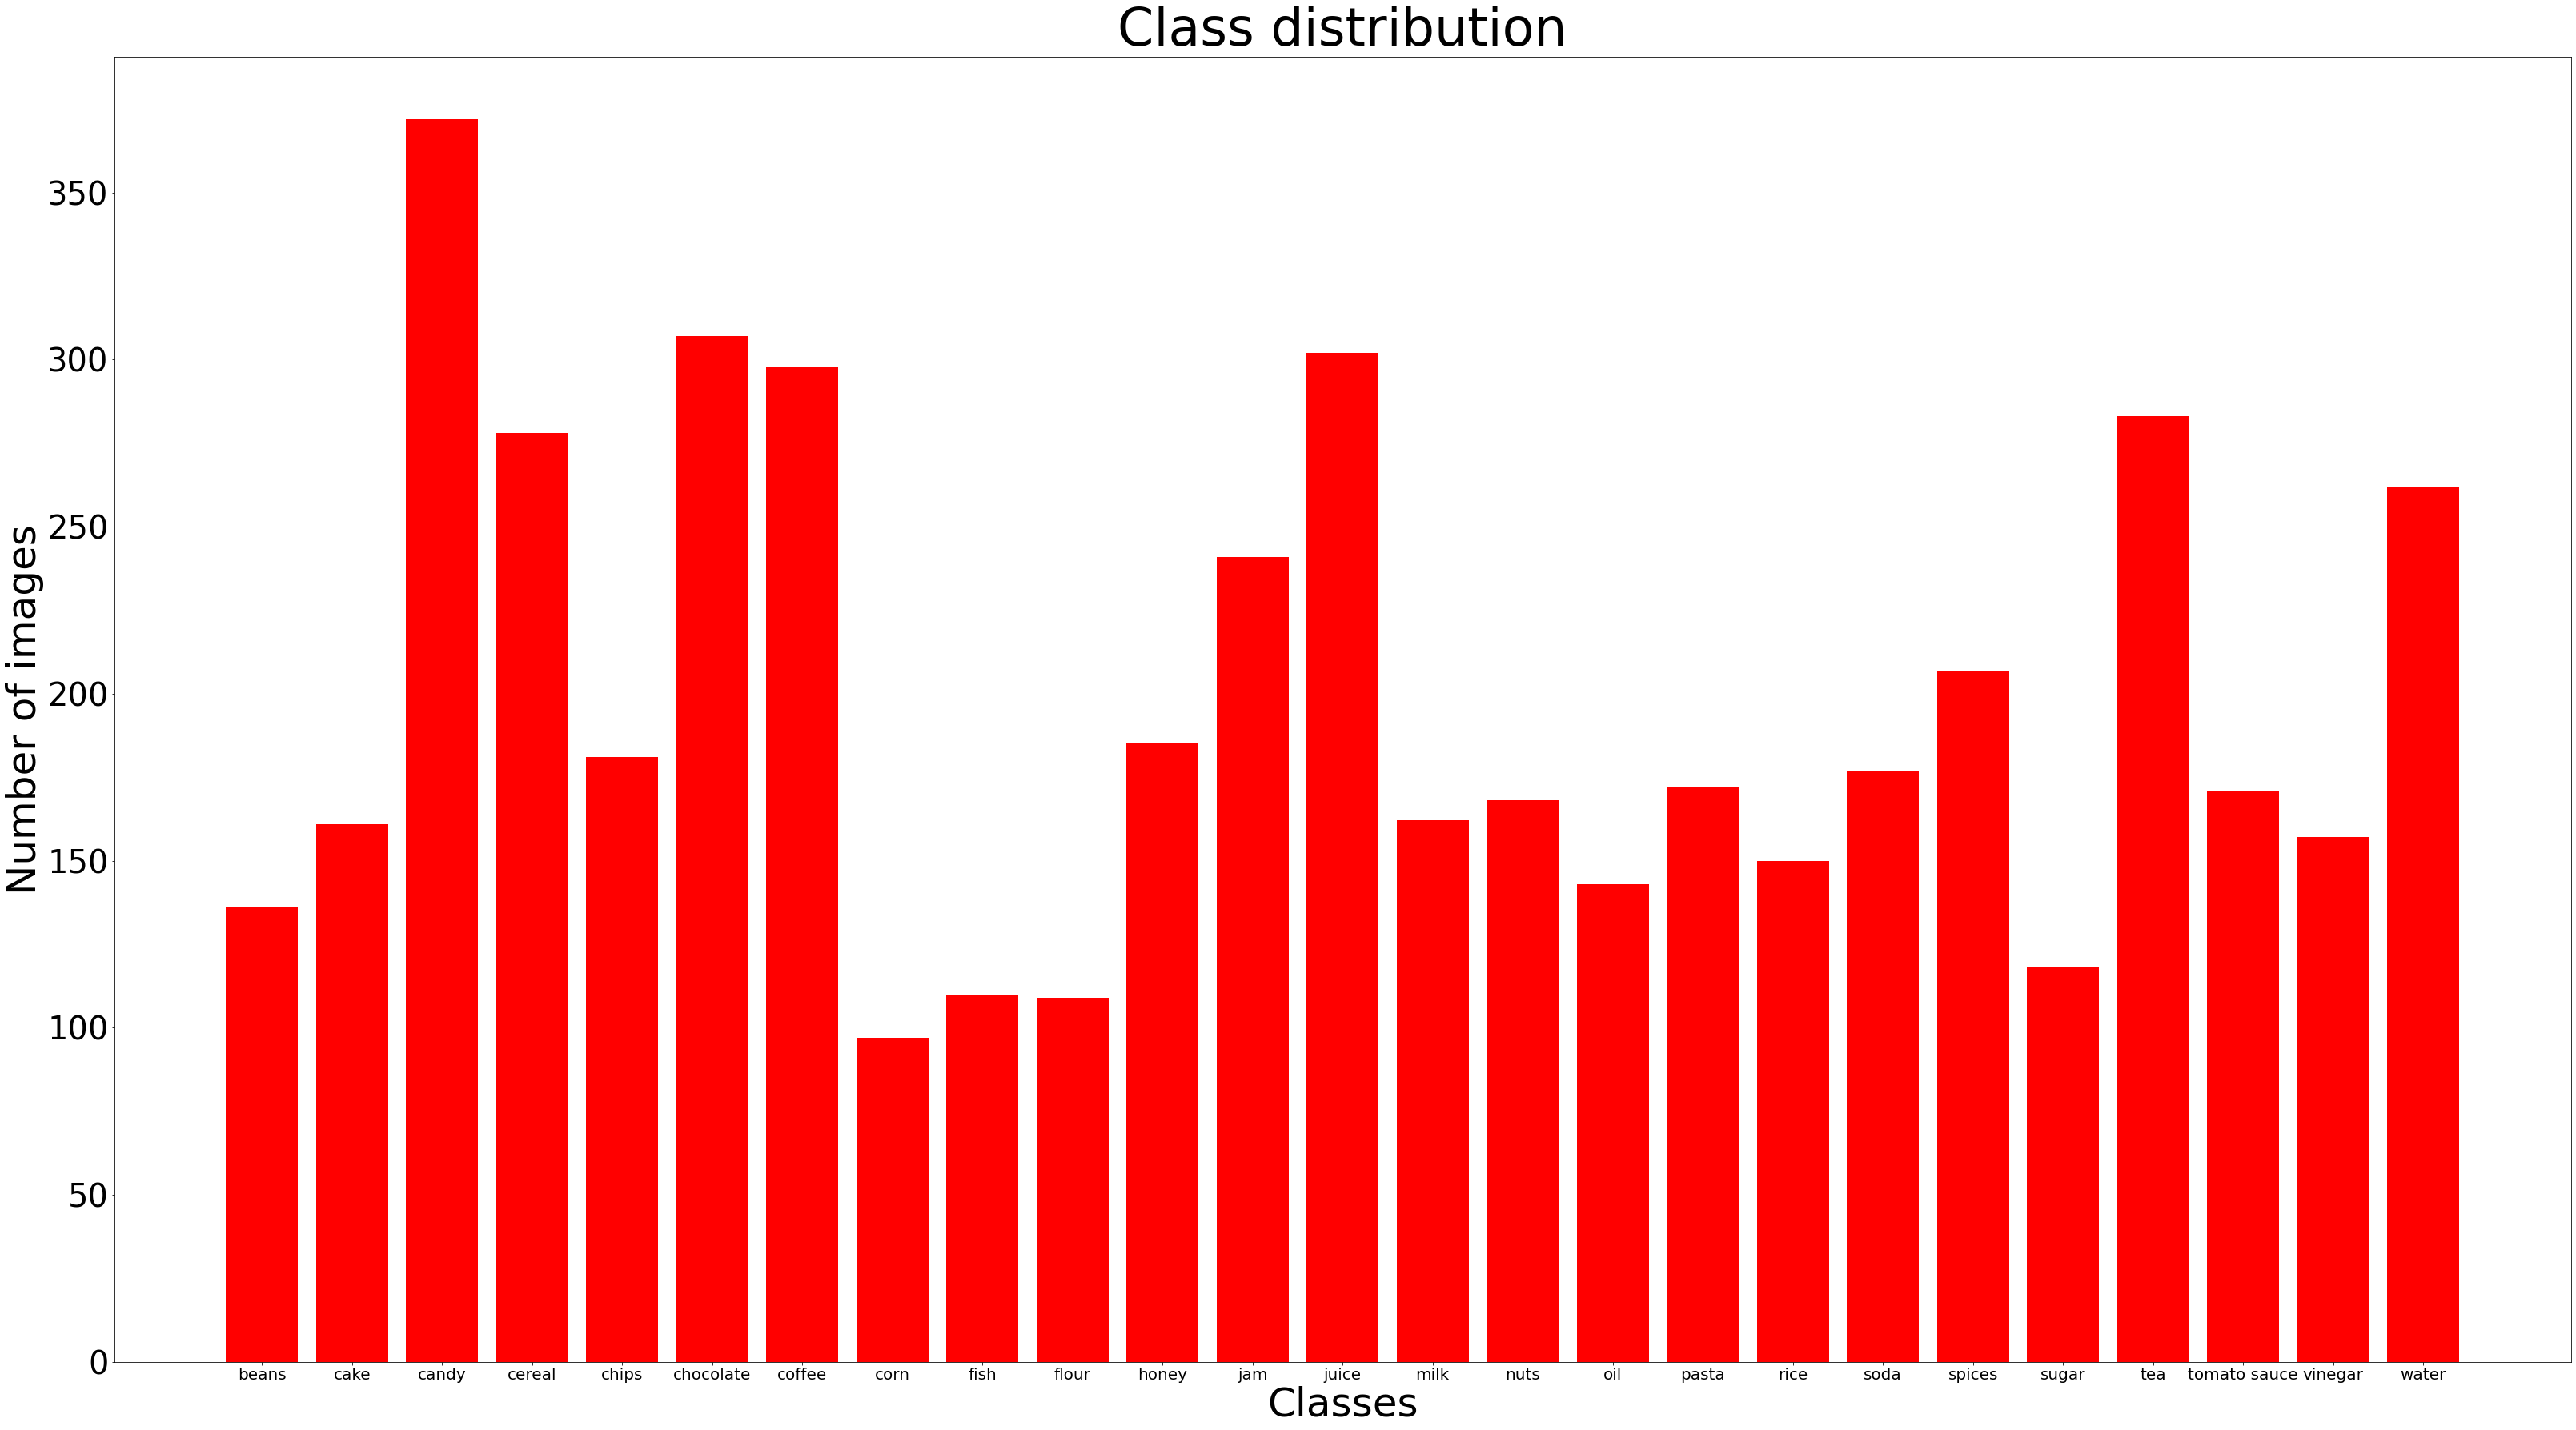

In [384]:
# bar diagram of class distribution
classes_names = ['beans','cake','candy','cereal','chips','chocolate','coffee','corn','fish','flour','honey',
                'jam','juice','milk','nuts','oil','pasta','rice','soda','spices','sugar','tea','tomato sauce','vinegar','water']
plt.figure(figsize=(55,30))
plt.title('Class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(Y), color = 'r')
plt.show()

In [385]:
Y = to_categorical(Y,25)

In [386]:
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [387]:
# data scaling
X = np.array(X)
X = X.astype('float32')
X=X/255

In [388]:
X.shape,Y.shape

((4947, 150, 150, 3), (4947, 25))

In [389]:
# train - test - val split
# x_train_val, x_test, y_train_val, y_test = train_test_split(X,Y,test_size=0.2,random_state=RANDOM_STATE,stratify=Y)
# x_train, x_val, y_train, y_val = train_test_split(x_train_val,y_train_val,test_size=0.2,random_state=RANDOM_STATE,stratify=y_train_val)
# x_train.shape,y_train.shape,x_val.shape,y_val.shape,x_test.shape,y_test.shape

# split only on x_train - y_train because we will use ImageDataGenerator on x_train for validation instances
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.3,random_state=RANDOM_STATE,stratify=Y)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3462, 150, 150, 3), (1485, 150, 150, 3), (3462, 25), (1485, 25))

In [390]:
# CHECK IF X_TEST HAVE ALL CLASSES

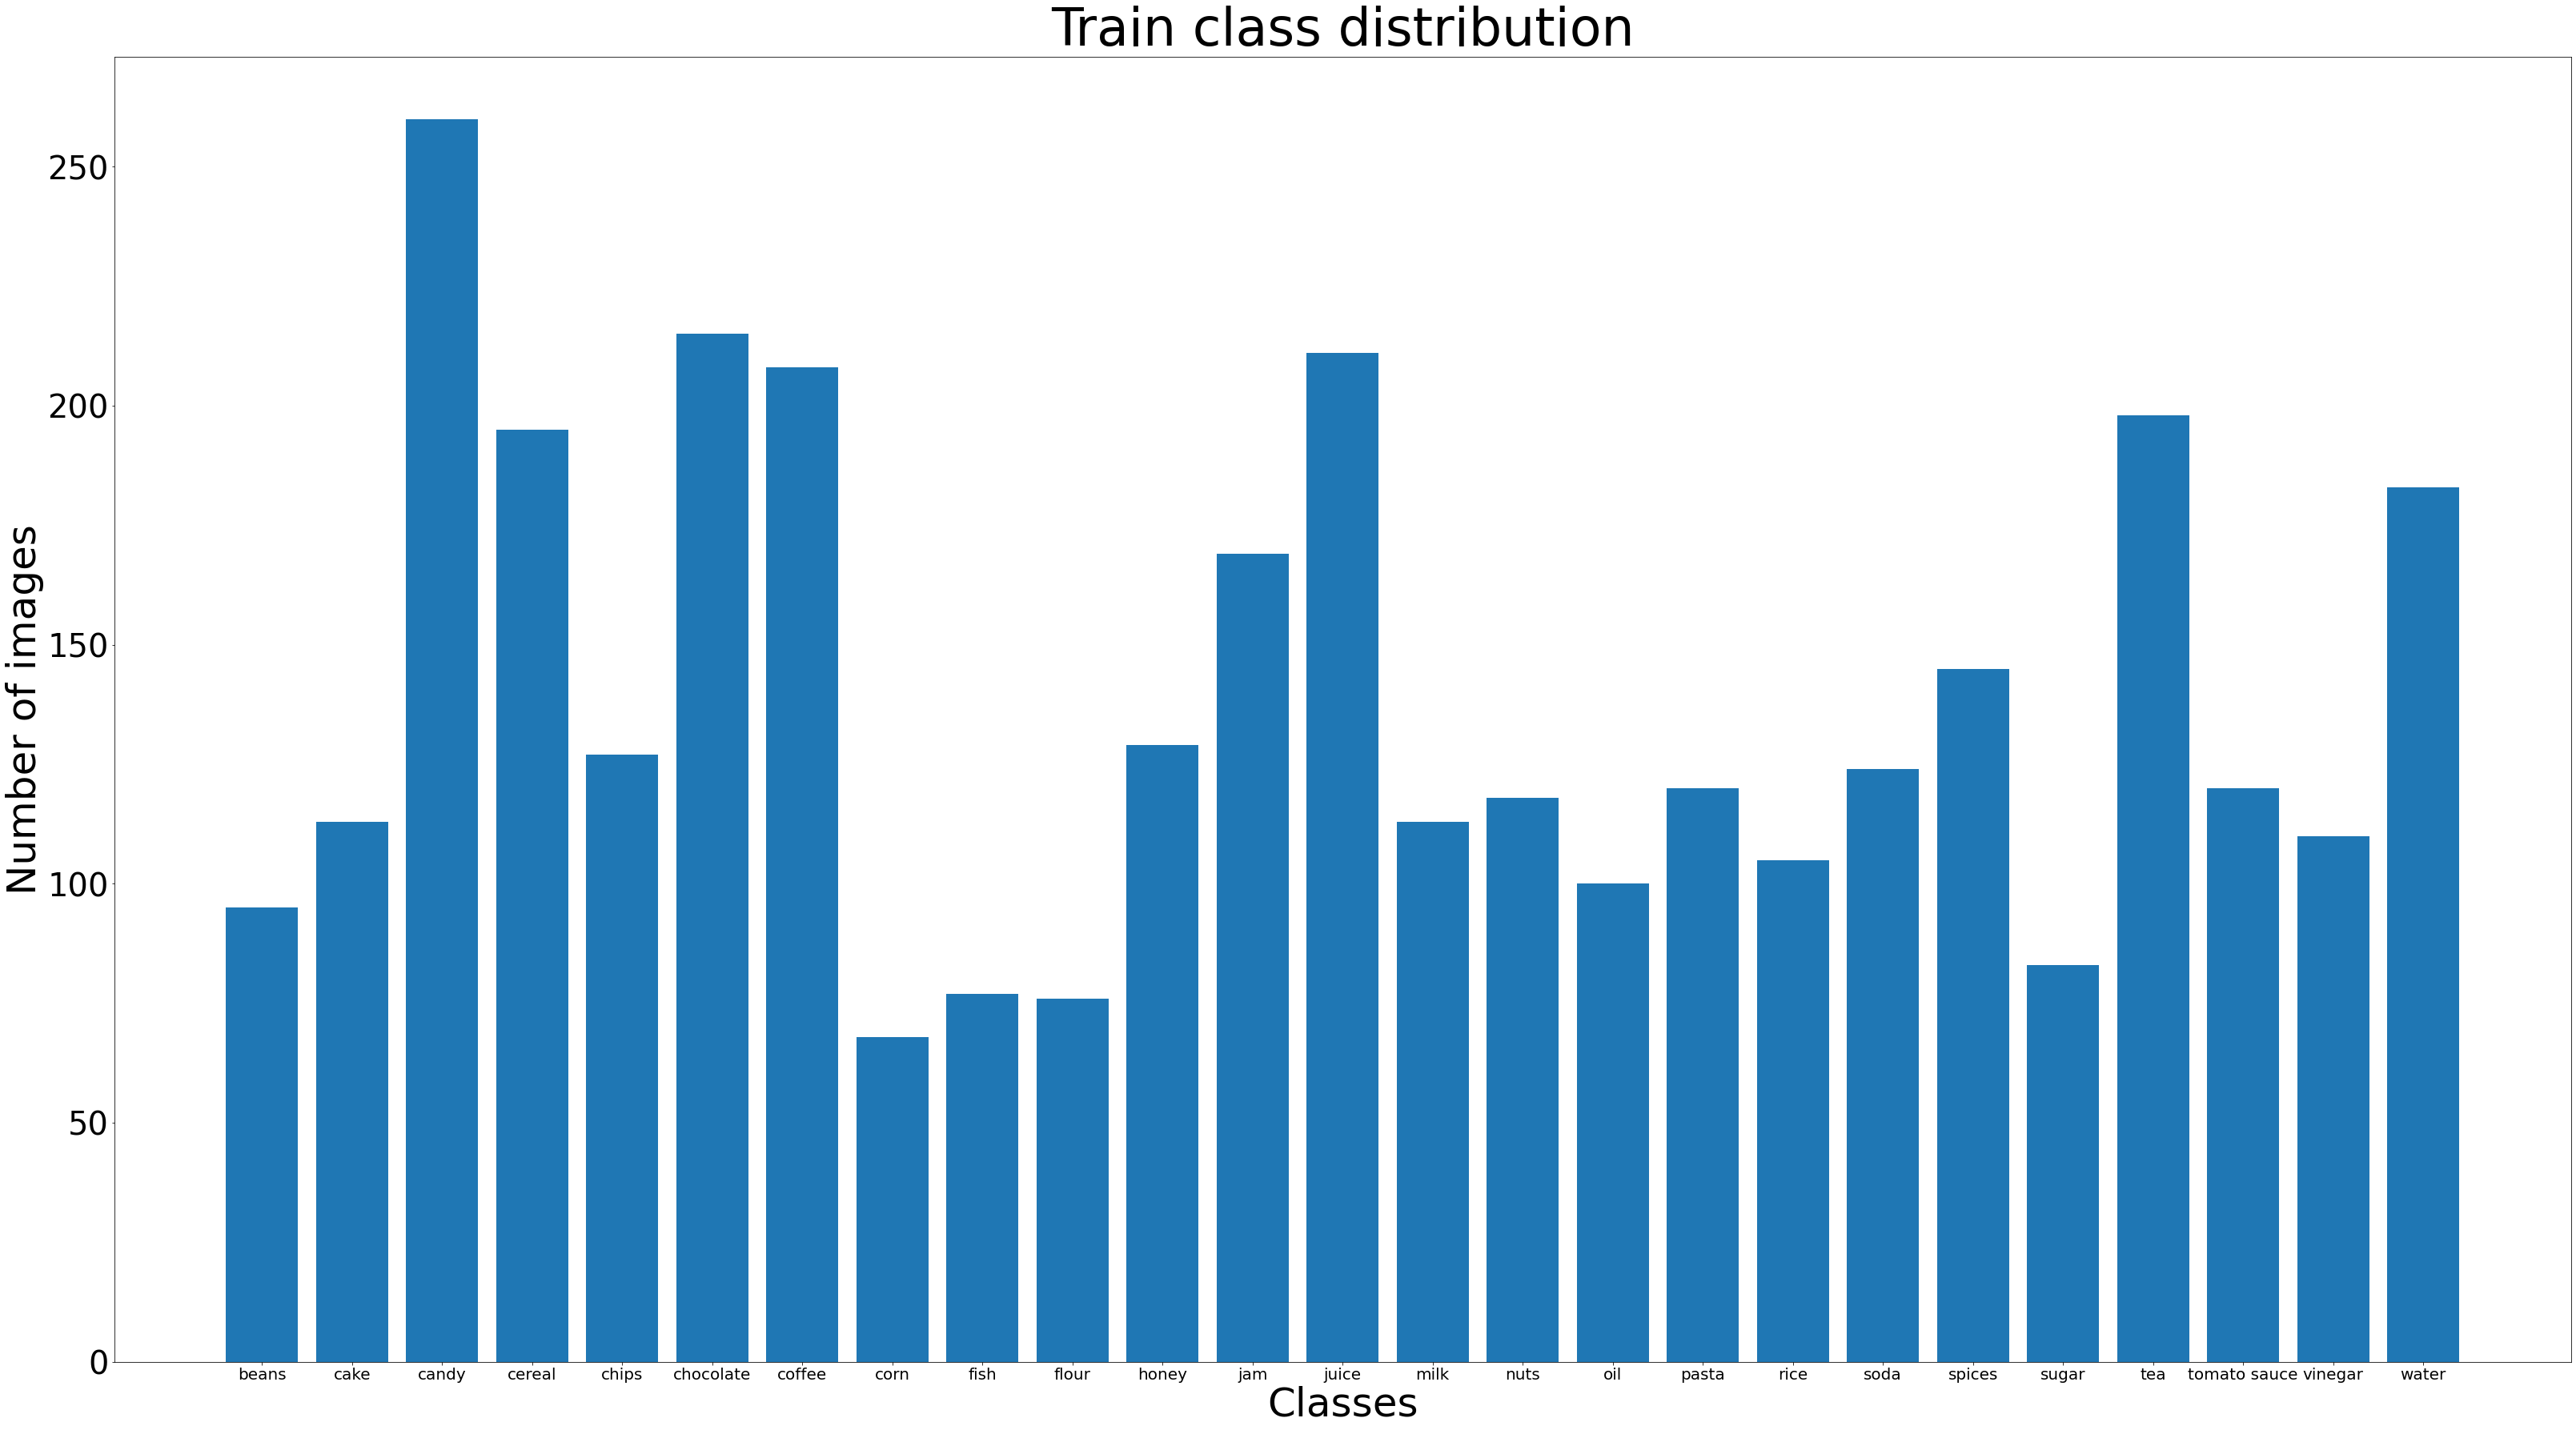

In [391]:
y_train_cls = np.argmax(y_train, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Train class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_train_cls))
plt.show()

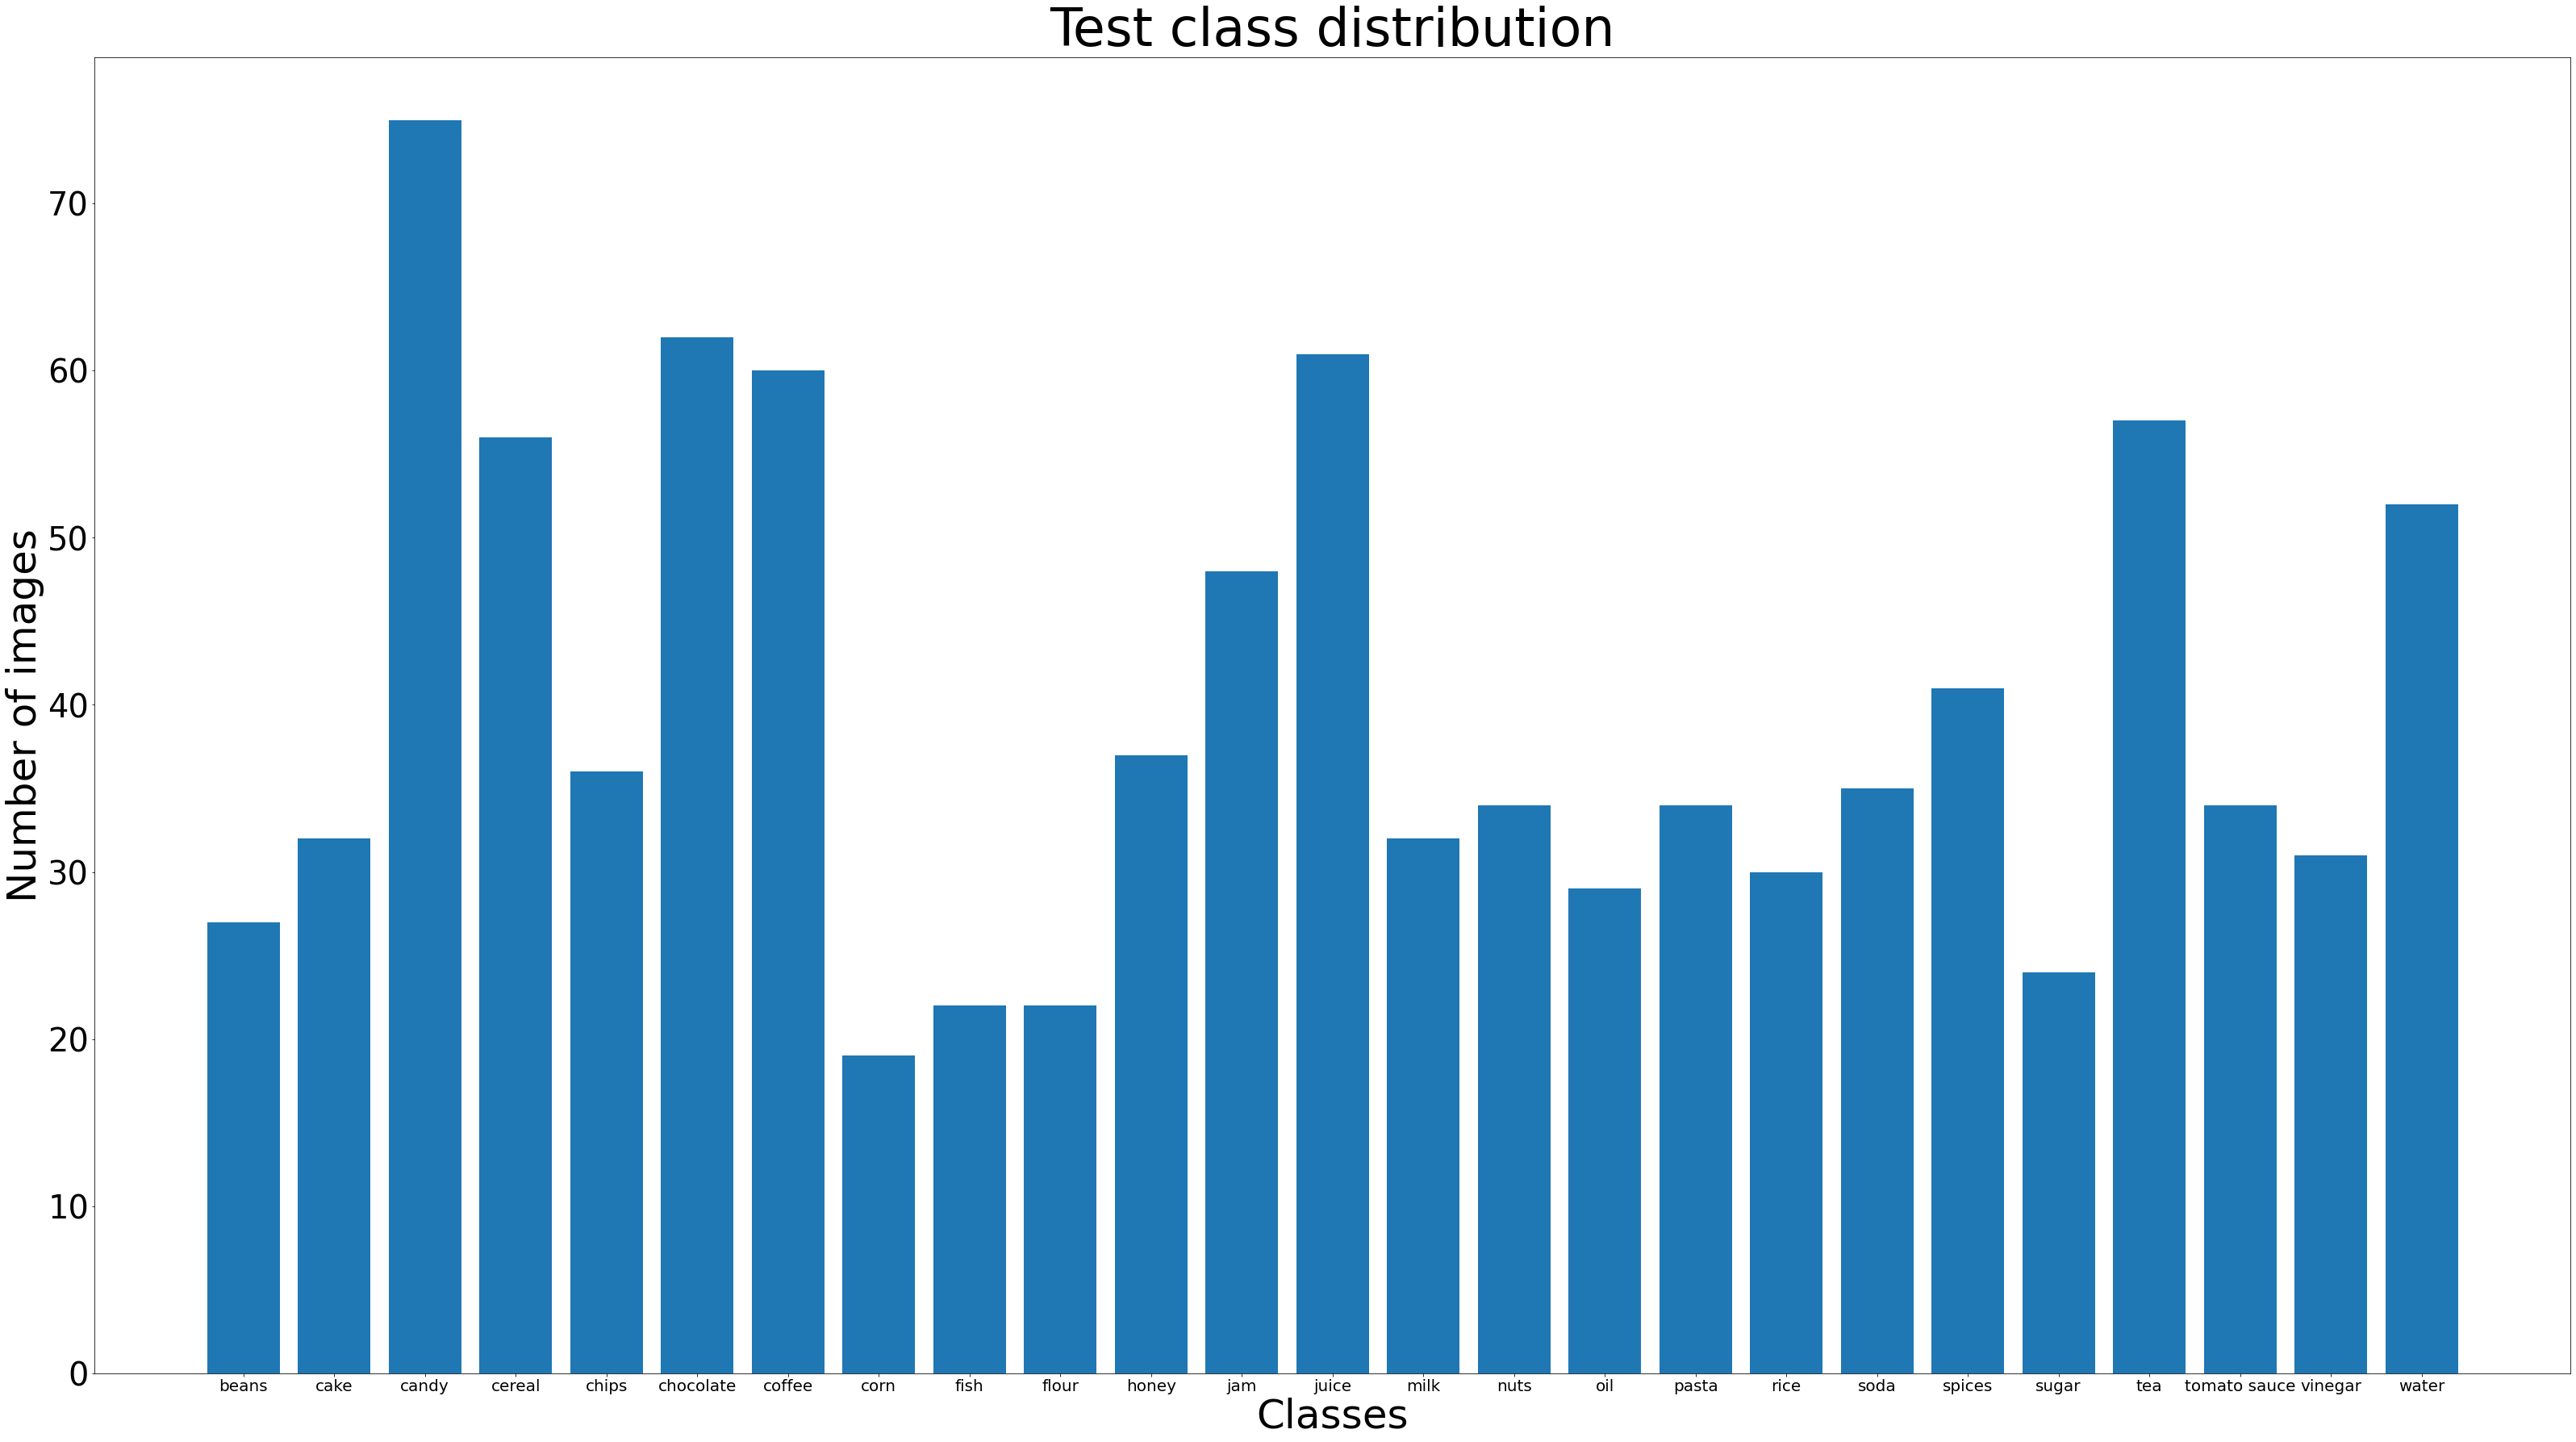

In [392]:
y_test_cls = np.argmax(y_test, axis = 1)
plt.figure(figsize=(55,30))
plt.title('Test class distribution', fontsize=65)
plt.xlabel('Classes', fontsize=50)
plt.ylabel('Number of images', fontsize=50)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 40)
plt.bar(classes_names,np.bincount(y_test_classes))
plt.show()

In [393]:
# image data generator
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False,
        validation_split=0.3) 

augs_gen.fit(x_train)

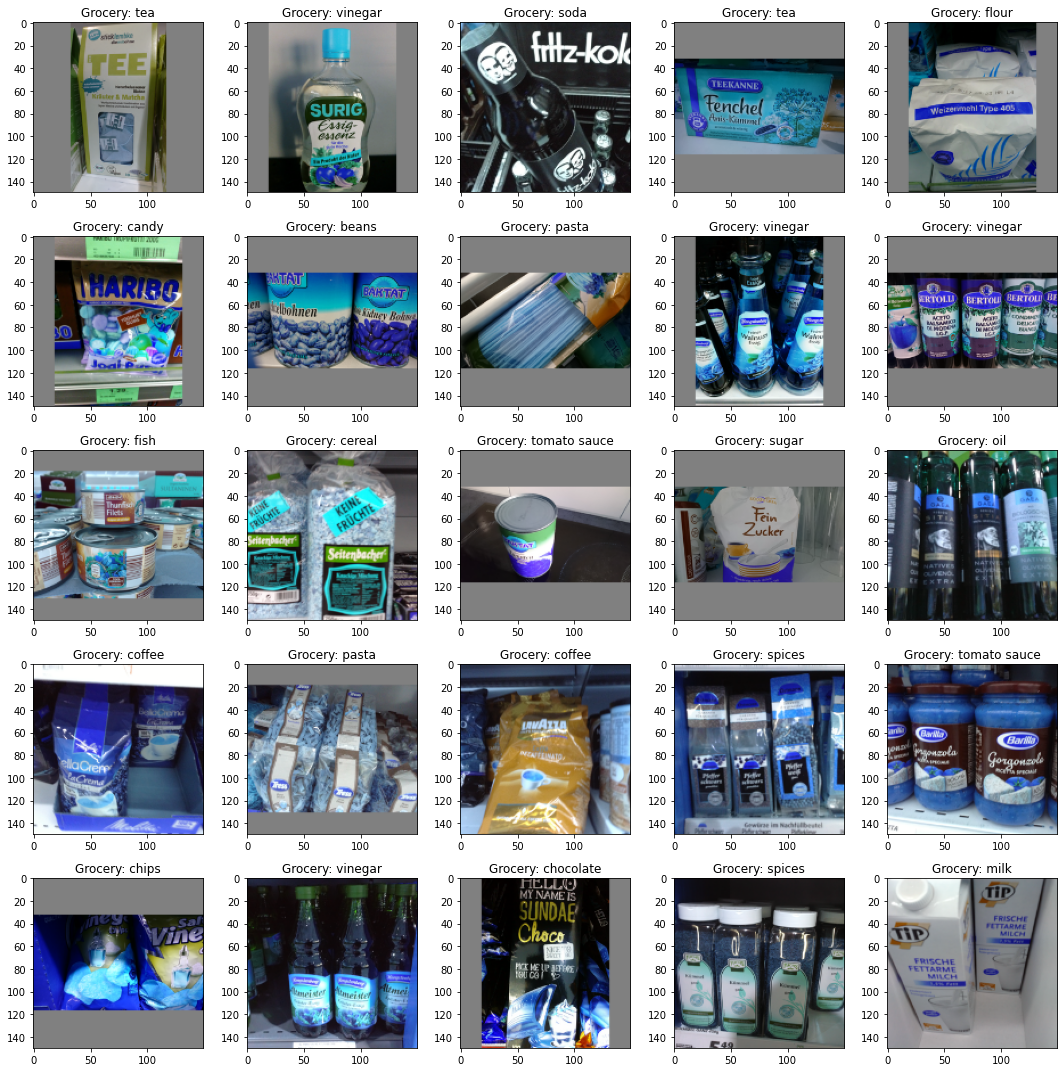

In [394]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        k = rn.randint(0, len(Z))
        ax[i,j].imshow(X[k])
        ax[i,j].set_title('Grocery: '+ Z[k])
        
plt.tight_layout()

In [395]:
img_rows = imgsize
img_cols = imgsize
img_rows, img_cols

(150, 150)

In [396]:
# channels_last img format
input_shape = (img_rows, img_cols, 3)
number_of_classes = 25

In [397]:
# model = test_model()
model = vgg16_model(img_rows, img_cols)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001F289E6AA90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F2DFB660A0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F291783F10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F29334AAF0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F2DEDB77F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F291788250> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F28A0C6820> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F2938A89A0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F2DE4102E0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001F286BFB9D0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001F2917886A0> False
<tensorflow.python.

In [398]:
print_model(model, path_to_vgg16_model_image)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [399]:
checkpoint = ModelCheckpoint(
    filepath=path_to_vgg16_model_weights,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

# TensorBoard provides the visualization
# tensorboard = TensorBoard(
#     log_dir = './vgg16logs',
#     histogram_freq=0,
#     batch_size=16,
#     write_graph=True,
#     write_grads=True,
#     write_images=False,
# )

csvlogger = CSVLogger(
    filename= path_to_vgg16_csvlog,
    separator = ",",
    append = False
)


# Reduce learning rate when a metric has stopped improving
# reduce = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.1,
#     patience=3,
#     verbose=1, 
#     mode='auto'
# )

callbacks = [checkpoint, csvlogger]

In [400]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history = model.fit(
                    augs_gen.flow(x_train, y_train, batch_size = 32,  subset='training'),
                    epochs = num_of_epochs,
                    verbose = 1,
                    validation_data  = augs_gen.flow(x_train, y_train, batch_size=8, subset='validation'),
                    callbacks=callbacks
                    )

Epoch 1/50
76/76 [==============================] - 268s 4s/step - loss: 2.8920 - accuracy: 0.1790 - val_loss: 2.5585 - val_accuracy: 0.2697
Epoch 2/50
76/76 [==============================] - 262s 3s/step - loss: 2.3490 - accuracy: 0.3164 - val_loss: 2.2703 - val_accuracy: 0.3333
Epoch 3/50
76/76 [==============================] - 260s 3s/step - loss: 2.0737 - accuracy: 0.3915 - val_loss: 2.0667 - val_accuracy: 0.4094
Epoch 4/50
76/76 [==============================] - 259s 3s/step - loss: 1.9154 - accuracy: 0.4282 - val_loss: 2.0060 - val_accuracy: 0.4104
Epoch 5/50
76/76 [==============================] - 258s 3s/step - loss: 1.8194 - accuracy: 0.4641 - val_loss: 1.9380 - val_accuracy: 0.4297
Epoch 6/50
76/76 [==============================] - 258s 3s/step - loss: 1.6828 - accuracy: 0.5012 - val_loss: 1.8660 - val_accuracy: 0.4653
Epoch 7/50
76/76 [==============================] - 258s 3s/step - loss: 1.5961 - accuracy: 0.5206 - val_loss: 1.9170 - val_accuracy: 0.4480
Epoch 8/50
76

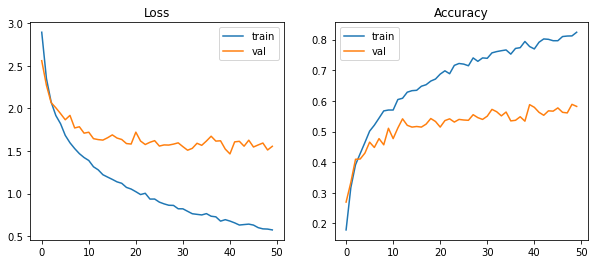

In [401]:
plot_acc_loss(history,num_of_epochs)

In [402]:
# MODEL EVALUATION

109/109 [==============================] - 252s 2s/step - loss: 0.6342 - accuracy: 0.8281
Test loss: 0.6341614127159119
Test accuracy: 0.8281340003013611
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        95
           1       0.77      0.84      0.81       113
           2       0.89      0.90      0.89       260
           3       0.75      0.72      0.74       195
           4       0.80      0.87      0.83       127
           5       0.65      0.84      0.73       215
           6       0.80      0.83      0.81       208
           7       0.94      0.85      0.89        68
           8       0.95      0.78      0.86        77
           9       0.92      0.72      0.81        76
          10       0.94      0.86      0.90       129
          11       0.95      0.91      0.93       169
          12       0.90      0.77      0.83       211
          13       0.92      0.82      0.87       113
          14       0.85      0.80  

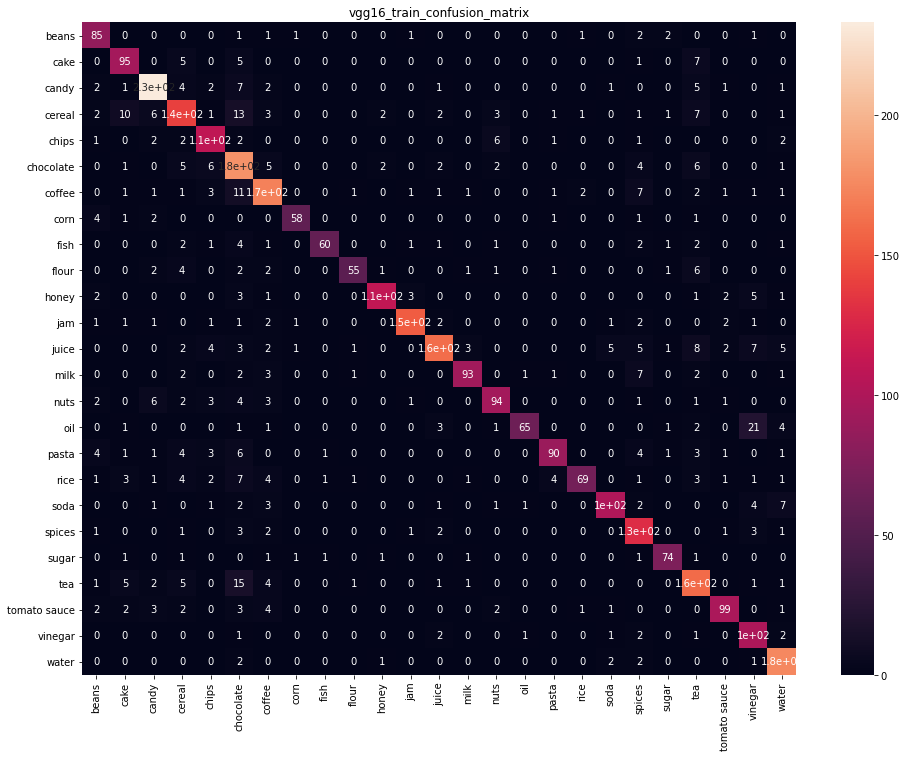

In [403]:
# TRAIN EVALUATION
evaluate_model(model,x_train,y_train,classes_names,"vgg16_train_confusion_matrix")

47/47 [==============================] - 126s 3s/step - loss: 1.4060 - accuracy: 0.6088
Test loss: 1.4060096740722656
Test accuracy: 0.6087542176246643
              precision    recall  f1-score   support

           0       0.47      0.66      0.55        41
           1       0.53      0.67      0.59        48
           2       0.71      0.71      0.71       112
           3       0.60      0.57      0.58        83
           4       0.58      0.63      0.60        54
           5       0.40      0.66      0.50        92
           6       0.57      0.51      0.54        90
           7       0.71      0.59      0.64        29
           8       0.78      0.55      0.64        33
           9       0.48      0.36      0.41        33
          10       0.78      0.57      0.66        56
          11       0.77      0.69      0.73        72
          12       0.68      0.52      0.59        91
          13       0.70      0.57      0.63        49
          14       0.81      0.60    

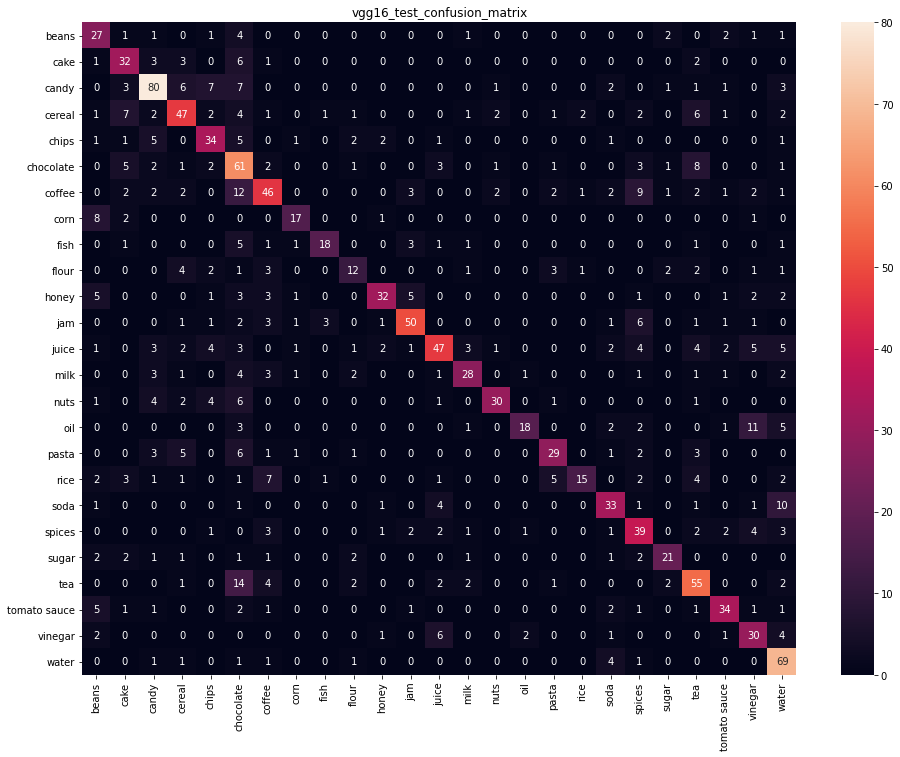

In [404]:
# TEST EVALUATION
evaluate_model(model,x_test,y_test,classes_names,"vgg16_test_confusion_matrix")

In [405]:
# take weights with max acc
# ret = model.load_weights(path_to_vgg1_model_weights)

In [406]:
# SAVING MODEL

In [407]:
write_model_as_json(model,vgg16_model_json_path)

In [408]:
model.save(path_to_vgg16_model)

INFO:tensorflow:Assets written to: ./models/vgg16\assets


In [409]:
# model1 = load_model(path_to_vgg16_model)

In [410]:
# evaluate_model(model1,x_test,y_test,classes_names)

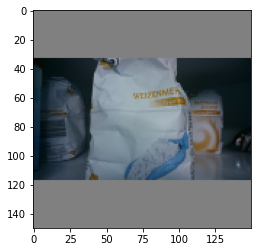

In [411]:
plt.imshow(x_test[12])
plt.show()

In [413]:
np.argmax(y_test[12])

9

In [414]:
classes_names[9]

'flour'

In [416]:
np.argmax(model.predict(x_test[12:13]))

9

In [417]:
classes_names[9]

'flour'

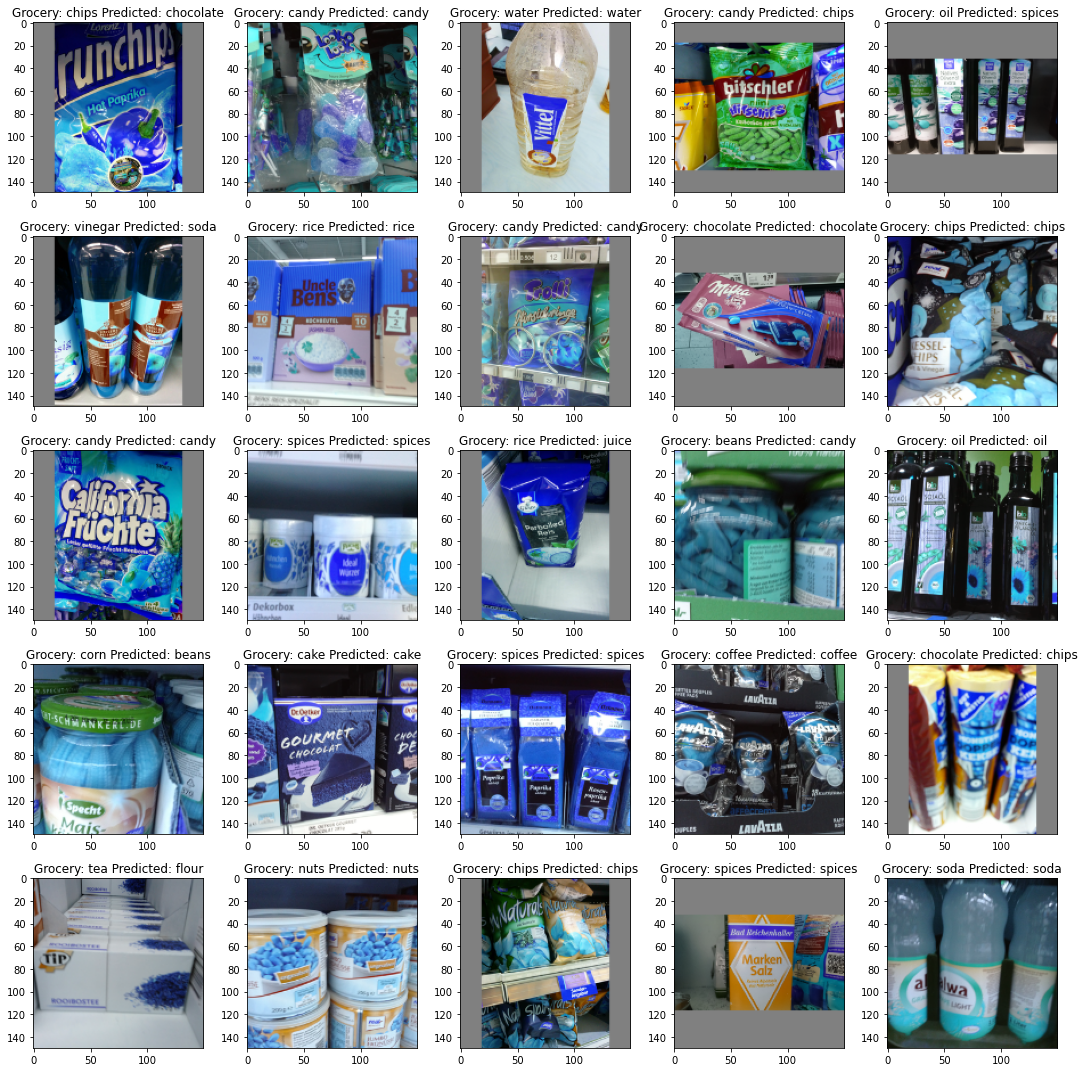

In [422]:
test_len = len(y_test)


fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(5):
        k = rn.randint(0, test_len)
        ax[i,j].imshow(x_test[k])
        ax[i,j].set_title('Grocery: '+ classes_names[np.argmax(y_test[k])] + " Predicted: " + classes_names[np.argmax(model.predict(x_test[k:k+1]))])
plt.tight_layout()  